### Задание

1. *Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)
3. Повторить п.2, но используя уже не медиану, а max
4. *Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
подсказка 2: нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VasiliyBarovLAPTOP\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\VASILI~1\AppData\Local\Temp/ipykernel_1888/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 24.7 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 7s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[22]

'заместитель'

Все просто - это словарь наших слов

Запускаем обучение

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 50 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.027020393), (10, 0.1467679), (11, 0.07569463), (17, 0.73157895)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: миссия ск медицина ухо прибытие выложить электроника
topic_1: сведение рекомендовать констатировать ближний взрывной химия нация
topic_2: риск гражданин рост доллар уровень это сравнение
topic_3: белоруссия китайский захватить рт золото армения nn
topic_4: тело женщина пациент жертва активность мужчина доклад
topic_5: год который это компания суд ребёнок свой
topic_6: налог памятник законодательство мышь зарплата виза конструкция
topic_7: мозг специальный учебный употребление школа заведение сочи
topic_8: конкурс испытание площадь содержать характерный распоряжение зуб
topic_9: год рубль банк млн nn компания составить
topic_10: журнал год производитель nn прогноз мировой первый
topic_11: человек который город nn также источник это
topic_12: остров вода снизить снизиться сократиться япония диапазон
topic_13: год это мочь который проект новый научный
topic_14: газ смерть турецкий год турция умереть скончаться
topic_15: украина украинский ракета погибнуть гражданин киев который
t

Напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.015648,0.0,...,0.00000,0.0,0.056421,0.0,0.0,0.0,0.0,0.0,0.104502,0.0
1,4896,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.409187,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,4897,0.0,0.0,0.0,0.02702,0.0,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.731639,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,4898,0.0,0.0,0.0,0.00000,0.0,0.31049,0.0,0.000000,0.0,...,0.00000,0.0,0.446140,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,4899,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,...,0.91328,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


#### векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[2356]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06251864, 0.        , 0.        , 0.        , 0.05579209,
       0.        , 0.03864912, 0.01832775, 0.04429038, 0.        ,
       0.03630243, 0.21430667, 0.        , 0.        , 0.        ,
       0.01716378, 0.        , 0.        , 0.49325475, 0.        ])

In [23]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [24]:
get_user_embedding(user_articles_list)

array([0.        , 0.01766117, 0.01360541, 0.        , 0.0062371 ,
       0.03867406, 0.        , 0.        , 0.03275562, 0.04442472,
       0.01608081, 0.12245291, 0.00231697, 0.06934884, 0.00793858,
       0.04908061, 0.10853834, 0.00528825, 0.        , 0.02137517,
       0.        , 0.        , 0.        , 0.43304526, 0.        ])

In [25]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [26]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.00000,0.007187,0.000000,0.005325,0.008359,0.197385,0.008540,0.011768,0.000000,...,0.161330,0.087227,0.023983,0.0,0.048550,0.009393,0.002655,0.000000,0.124897,0.036333
1,u108690,0.00000,0.000000,0.013418,0.000000,0.003052,0.128953,0.002921,0.000000,0.016007,...,0.131227,0.105497,0.056261,0.0,0.000000,0.005749,0.000000,0.003064,0.326246,0.000000
2,u108339,0.00501,0.012385,0.012387,0.000000,0.011848,0.062453,0.003226,0.000000,0.012945,...,0.100398,0.045424,0.000000,0.0,0.011166,0.006938,0.000000,0.000000,0.347051,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [28]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [29]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.00000,0.007187,0.000000,0.005325,0.008359,0.197385,0.008540,0.011768,0.000000,...,0.087227,0.023983,0.0,0.048550,0.009393,0.002655,0.000000,0.124897,0.036333,0
1,u108690,0.00000,0.000000,0.013418,0.000000,0.003052,0.128953,0.002921,0.000000,0.016007,...,0.105497,0.056261,0.0,0.000000,0.005749,0.000000,0.003064,0.326246,0.000000,1
2,u108339,0.00501,0.012385,0.012387,0.000000,0.011848,0.062453,0.003226,0.000000,0.012945,...,0.045424,0.000000,0.0,0.011166,0.006938,0.000000,0.000000,0.347051,0.000000,1


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [32]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12132969, 0.06239113, 0.56719466, 0.12475848, 0.06589746,
       0.05563968, 0.06242942, 0.02240917, 0.13831351, 0.2000468 ])

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

In [35]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

Best Threshold_mean=0.256707, F-Score_mean=0.642, Precision_mean=0.604, Recall_mean=0.686


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1645  110]
 [  78  167]]


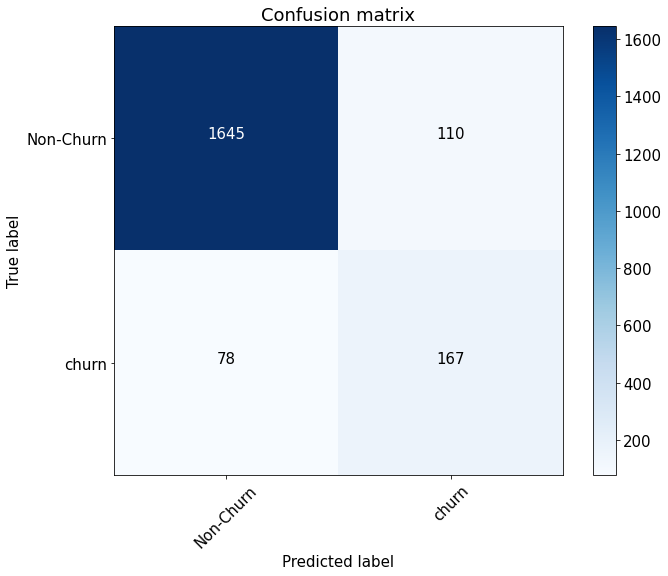

In [38]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_mean[ix_mean])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [39]:
roc_mean = roc_auc_score(y_test, preds)

#### Используем медиану для модификации кода функции get_user_embedding

In [40]:
def get_user_embedding_median(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0) 
    return user_vector

In [41]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(25)]]

Wall time: 636 ms


In [42]:
X = pd.merge(user_embeddings, target, 'left')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [44]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10062323, 0.08848873, 0.58930671, 0.11565809, 0.04607018,
       0.0176269 , 0.0947707 , 0.01361762, 0.1399595 , 0.13809892])

In [46]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print(f'Best Threshold_median={thresholds_median[ix_median]}, F-Score_median={fscore_median[ix_median]:.3f},Precision_median={precision_median[ix_median]:.3f}, Recall_median={recall_median[ix_median]:.3f}')                                                                        

Best Threshold_median=0.2345315327133813, F-Score_median=0.719,Precision_median=0.609, Recall_median=0.878


In [47]:
roc_median = roc_auc_score(y_test, preds)

#### Используем max для модификации кода функции get_user_embedding

In [48]:
def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0) 
    return user_vector

In [49]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(25)]]

Wall time: 312 ms


In [50]:
X = pd.merge(user_embeddings, target, 'left')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [52]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [53]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12959358, 0.00227674, 0.8863382 , 0.12342655, 0.04017364,
       0.0088406 , 0.36910498, 0.02515163, 0.01488473, 0.19560451])

In [54]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print(f'Best Threshold_max={thresholds_max[ix_max]}, F-Score_max={fscore_max[ix_max]:.3f}, Precision_max={precision_max[ix_max]:.3f}, Recall_max={recall_max[ix_max]:.3f}')                                                                        

Best Threshold_max=0.362722719295203, F-Score_max=0.759, Precision_max=0.827, Recall_max=0.702


In [55]:
roc_max = roc_auc_score(y_test, preds)

### Итог

In [91]:
listname = ['Mean', 'Median', 'MAX']
listThreshold = [thresholds_mean[ix_mean], thresholds_median[ix_median], thresholds_max[ix_max]]
listScore = [fscore_mean[ix_mean], fscore_median[ix_median], fscore_max[ix_max]]
listPrecision = [precision_mean[ix_mean], precision_median[ix_median], precision_max[ix_max]]
listRecall = [recall_mean[ix_mean], recall_median[ix_median], recall_max[ix_max]]
listRock = [roc_mean, roc_median, roc_max]
columns = ['Threshold', 'Score', 'Precision', 'Recall', 'Roc']

dataFrame1 = pd.DataFrame(zip(listThreshold, listScore, listPrecision,listRecall, listRock), columns=columns, index=listname)

# Print the dataframe
dataFrame1

,Threshold,Score,Precision,Recall,Roc
Mean,0.256707,0.642447,0.604317,0.685714,0.933901
Median,0.234532,0.719064,0.609065,0.877551,0.961381
MAX,0.362723,0.759382,0.826923,0.702041,0.966845


#### Вывод
Среднее значение показывает веорятность того, на сколько заинтересует пользователя та или иная тема, т.е возможно пользователь прочтет её, возможно нет.
Показатель MAX - вероятность того, что статья точно будет прочитана.
По моему мнеиню, наиболее точно предпочтения пользователя описывает показатель Median